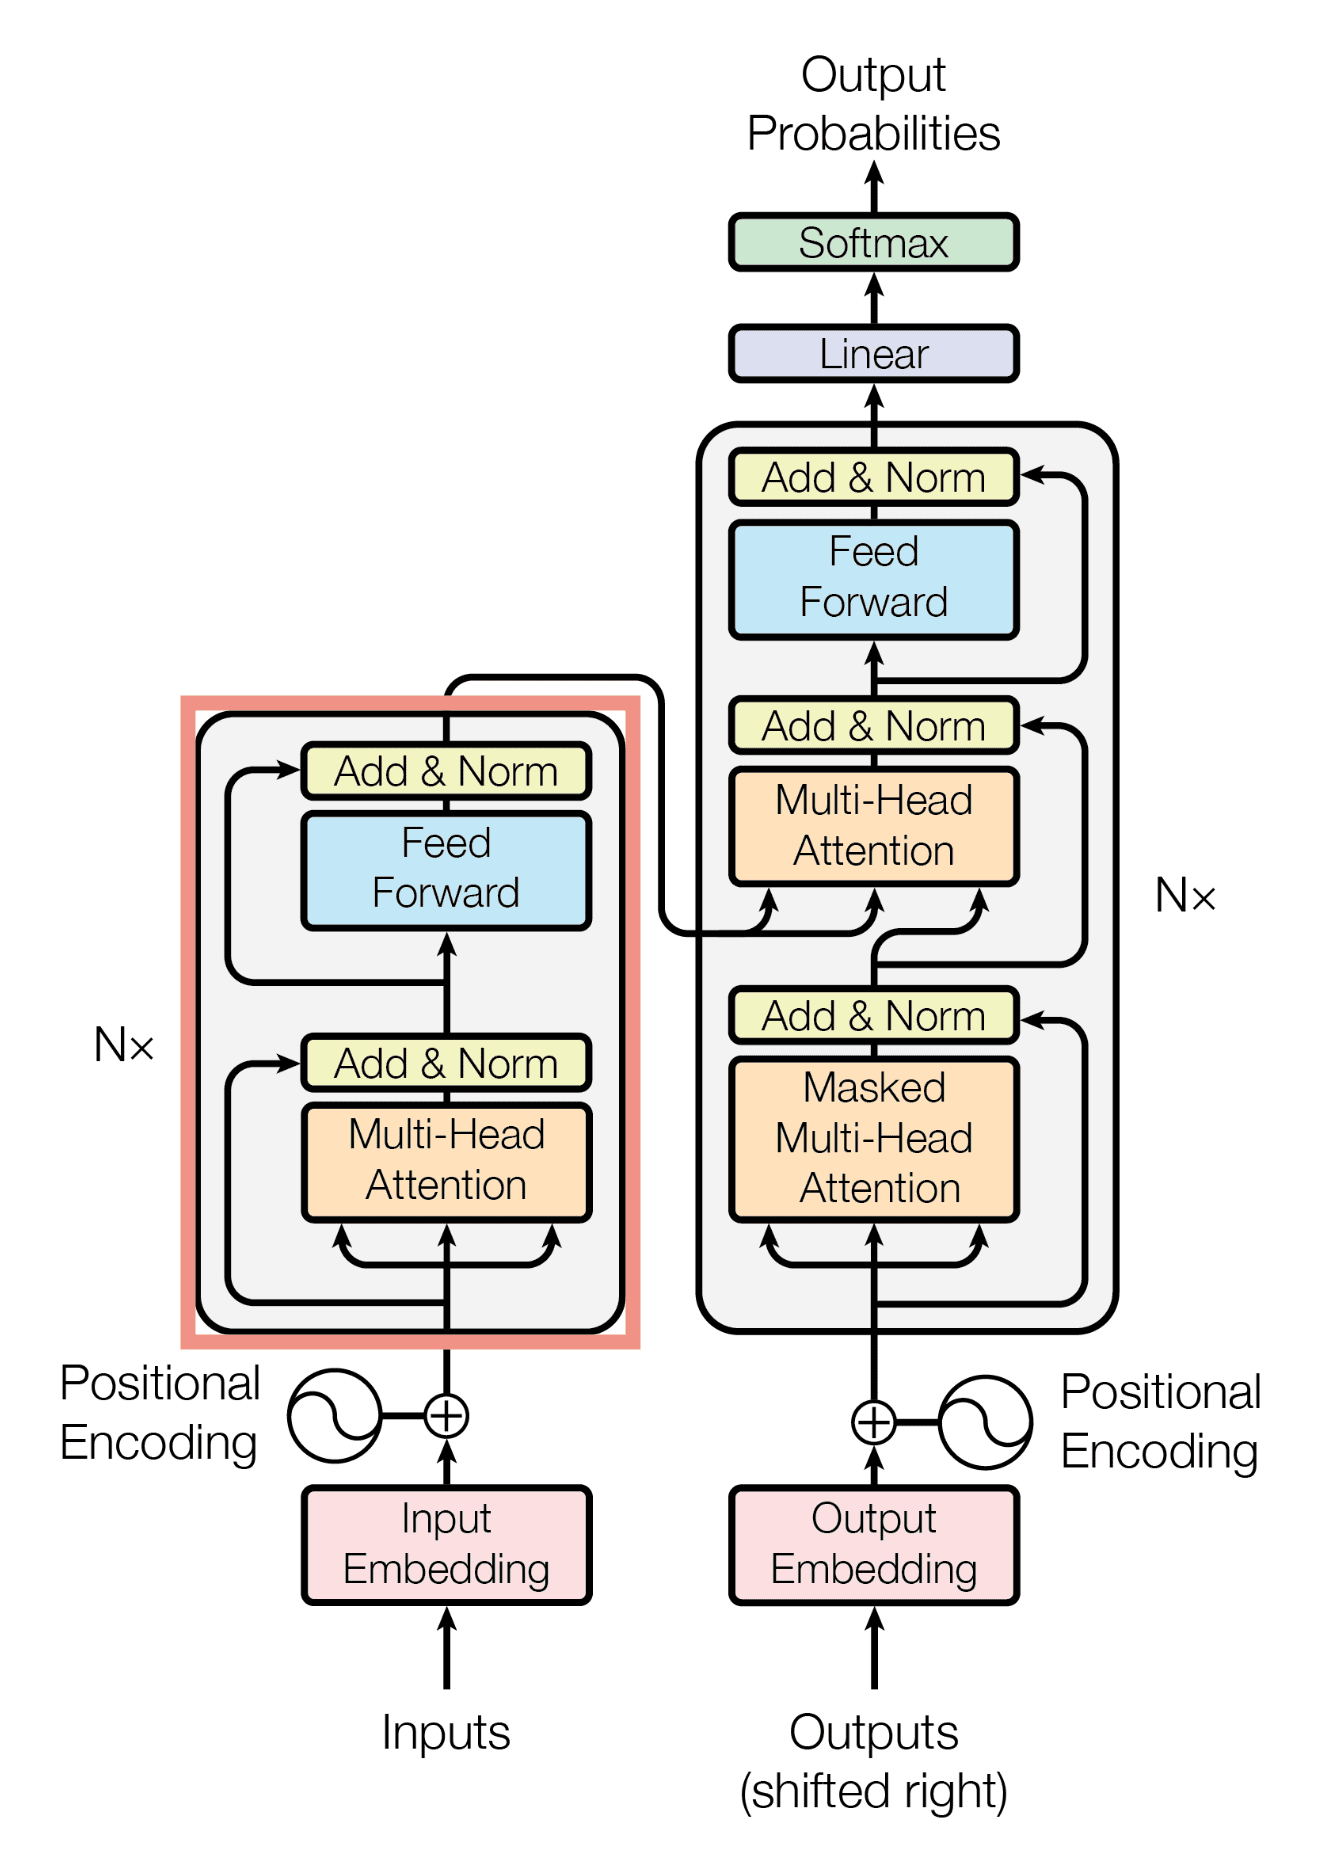

In [ ]:
# Thirs technical breakdown of position wise feed forward network
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, hidden, drop_prob=0.1):
    super().__init__()
    self.d_model = d_model
    self.hidden = hidden
    self.linear1 = nn.Linear(d_model, hidden) # 512 x 2048
    self.linear2 = nn.Linear(hidden, hidden) # 2048 x 512
    self.relu = nn.ReLU() # acitvation fucntion
    self.dropout = nn.Dropout(p=drop_prob)

  def forward(self, x): # 30 x 200 x d_model
    x = self.linear1(x) # 30 x 200 x 2048
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x) # 30 x 200 x 512
    return x


In [ ]:
# Breaking the second component of the encoder transformer i.e the layer normalization
class LayerNormalization(nn.Module):
  def __init__(self, parameters_shape, eps = 1e-5):
    super().__init__()
    self.parameters_shape = parameters_shape # this determined along which dimension layer normalization is to be applied , here batch and [512] dimension
    self.eps = eps # this is to make the division non zero as sd can be zero and it's in division
    self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512 dimensional tensor, it represents std deviation values
    self.beta = nn.Parameter(torch.zeros(parameters_shape)) # 512 dimensional tensor , it reperesents mean value as we learn along the network

  def forward(self, input): # 30 x 200 x 512
    dims = [-(i+1) for i in range(len(self.parameters_shape))] # dimesnion along which we want to peform layer normalization, it will be on layer dimension i.e 512
    mean = inputs.mean(dim=dims, keepdim=True) # calculate mean of the inputs for all the words , it will be 30 x 200 x 1
    print(f'Mean \n ({mean.size()}) : \n {mean}')
    var = ((inputs-mean)**2).mean(dim=dims, keepdim=True) # this is also 30 x 200 x 1
    std = (var + self.eps).sqrt()
    print(f'Standard Deviation \n ({std.size()}) : \n {std}')
    y = (inputs-mean)/std # normalization , the normalized value will be 30 x 200 x 512 [bs, seq_length, d_model], here mean = 0 and std dev ~ 1
    print(f"y \n ({y.size}) = \n {y}")
    out = self.gamma *y + self.beta # we have learnable params 30 x 200 x 512, we have one learnable param for entire batch and entire sequence of 512 dimension , we have 512 learnable param in gamma and beta individually
    print(f"out \n ({out.size()}) =. \n {out}")
    return out

In [ ]:
# Multi Head attention 1st technical breakdown
# Every single word is broken down into three vectors q, k, v . query vector q is like what I am looking for, k is what I have and v is what I offer from attention

def scaled_dot_product(q, k, v, mask=None): # This is basically attention for one head
  d_k = k.size()[-1] # get the dimension of k vector to normalize the scaled dot product in the attention. d_k is 64 for each head

  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # k is not for one word but for all words in the sentence and for all sentences in a  i.e k.transpose will give [batch_size, d_model, max_seq_length]
  # scaled is max_seq_length x max_seq_length dimension along with the batch. The normalization allows values in attention matrix to be close like mean 0 and std ~1 to have stable steps during backpropogation.

  # mask is required in decoder as we generate words in regressive manner hence we don't want to look into future to get the context it will be cheating.
  if mask is not None:
    scaled += mask # broadcasting as we are adding two different tensors of different dimension

  attention = F.softmax(scaled, dim=-1) # dim =-1 because attention values are stored in the last dimension of the scaled. This will make attention probabilities determining how much one word focuses on the other
  values = torch.matmul(attention, v) # this will give new set of values for each word. This value vector for the word basically has the context of how much to attend to other words

  return values, attention


class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads # this is basically 512/8 = 64 i.e dimension of k,q v for each head
    self.qkv_layer = nn.Linear(d_model, 3*d_model) # It basically contains qkv for all attention heads and hence 3 * 512 as 512 alone contains qkv of 8 heads each of dimension 64
    self.linear_layer = nn.Linear(d_model, d_model)


  def forward(self, x, mask=None):
    batch_size, sequence_lenght, d_model = x.size()
    qkv = self.qkv_layer(x) # this will basically gives qkv for each word in all 8 heads of attention
    qkv = qkv.reshape(batch_size, sequence_length, self.num_head, 3* self.head_dim) # here we have broken down the last dimension 3*d_model of qkv_layer into heads and 3 * 64 each for q, k and v
    qkv = qkv.permute(0, 2, 1, 3) # we now make it [batch_size, heads, sequence_length, 3*head_dim] 30  x 8 x 200 x 192
    q, k, v = qkv.chunk(3, dim=-1) # this will help us get qkv of all heads by chunking the last dimension  each of the q k and v will have dimension [batch_size, heads, max_Seq_length, head_dim]  30 x 8 x 200 x 64
    values , attention = scaled_dot_product(q, k, v, mask) # attention will have dimension [batch_size, 8 , 200, 200] and values will have [batch_size, heads, max_seq_length, 64 ]
    values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim ) # 30 x 200 x 512 rearranging back to original tensor shape
    out = self.linear_layer(values) # 30 x 200 x 512

    return out # returned to Encoder Layer


In [ ]:
# Follow the architecture above for this layer it is basically the component wise overview of encoder
class EncoderLayer(nn.Module):
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
    super().__init__()
    self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.norm1 = LayerNormalization(parameters_shape = [d_model])
    self.dropout1 = nn.Dropout(p=drop_prob)
    self.ffn = PositionwiseFeedForward(d_model=d_model, hidden_dim=ffn_hidden, drop_prob=drop_prob)
    self.norm2 = LayerNormalization(parameters_shape=[d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)

  def forward(self, x):
    # for residual connection keep the residual as it will be used in add and norm after MultiHeaded Attention
    residual_x = x
    x = self.attention(x, mask=None) # mask is none as in encoder we can look into future tokens but not in decoder
    x = self.dropout1(x)
    x = self.norm1(x + residual_x) # this performs adding residual and then layer normalization
    # this x is also used after feed forward as residual
    residula_x = x
    x = self.ffn(x)
    x = self.dropout2(x)
    x = self.norm2(x + residual_x)

    return x


In [ ]:
class Encoder(nn.Module): # every class part of network we will derive it's class from Module, it allows to perform many operations behind the scene like it's own forward which we override , state_dict, get_parameters etc.
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
    super().__init__()
    # sequential takes all the comma separated values and execute in forward pass one after another
    # here we take 5 encoder layers as num_layer = 5 and * basically helps to take list and deconstruct it into it's 5 components
    self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                  for i in range(num_layers)])

  # overriding the forward where fwd propogation is performed
  def forward(self, input):
    x = self.layers(input)
    # this will be the overall output from the transformer encoder layer
    return x

In [ ]:
# parameters

d_model = 512 #the final represenation learnt from the encode for each word will be of this dimension vector. ALmost eveywhere in the encoder it will be 512.

num_heads = 8 # It is used for multi-head attention. We perform attention 8 times in parallel, where QKV will be 8 different and for each QKV their respective self attn

drop_prob = 0.1 # It determines the droput where we switch off certain neurons, it allows NN to learn along different paths regularization technique where coefficients are penalized here neurons are not penalized but turned off
# drop prob basically helps the NN to generalize well instead of memorizing the data. It is helpful in deep network, 0.1 means 10% chance that a given neuron will be turned off at given stage.

batch_size = 30 # Multi examples at same time for faster and stable training (less fluctuation and less noisy gradient update)

max_seq_length = 200 # largest number of words in a sentence we have in our training dataset

ffn_hidden = 2048 # we have 512 out of attention in feed forward we expand and then get back to 512 to learn additional information.

num_layers = 5 # Number of encoder layers we want to use in the transformer layer


# create a encoder object and pass on all the values or params
encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)